## L-mode H-mode  Classifier

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import confinement_mode_classifier as cmc
from datetime import datetime
import time 
import torchvision
import torch
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

Seed set to 42


Device: cuda:0


In [2]:
path = Path(os.getcwd())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
batch_size = 32
shots = [16534, 16769, 16773, 18130, 19237, 19240, 19379, 18057, 16989]
shots_for_testing = [16769, 18130, 18057]
shots_for_validation = [19237]

shot_df, test_df, val_df, train_df = cmc.load_and_split_dataframes(path,shots, shots_for_testing, shots_for_validation )


test_dataloader = cmc.get_dloader(test_df, path=path, batch_size=batch_size)
val_dataloader = cmc.get_dloader(val_df, path=path, batch_size=batch_size)
train_dataloader = cmc.get_dloader(train_df, path=path, batch_size=batch_size)

### Create dataloader, that will be used in training

In [4]:
dataloaders = {'train':train_dataloader, 'val':val_dataloader}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

In [5]:
timestamp =  datetime.fromtimestamp(time.time()).strftime("%d-%m-%Y, %H-%M-%S ") + input('add comment: ')

# create grid of images
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{timestamp}')

KeyboardInterrupt: Interrupted by user

## Import ResNet pretrained model
### And freeze all layers except last f.c. layer


In [ ]:
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1', )
for param in pretrained_model.parameters():
    param.requires_grad = False
 
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM
pretrained_model = pretrained_model.to(device)

### Hyperparameters

In [ ]:
#
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001) #pouzit adam

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Train last fc of the model

In [ ]:

pretrained_model.load_state_dict(torch.load(f'{path}/runs/14-12-2023, 13-18-26 Compairing frozen and unfrozen models/model_fully_trained.pt'))

<All keys matched successfully>

In [ ]:
pretrained_model.eval()
pretrained_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_epochs = 2
#model = cmc.train_model(pretrained_model, criterion, optimizer, exp_lr_scheduler, 
#                        dataloaders, writer, dataset_sizes, num_epochs=num_epochs, comment = 'fc training')
#model_path = Path(f'{path}/runs/{timestamp}/model_fc_trained.pt')
#torch.save(model.state_dict(), model_path)

### Test model with last fc trained

In [ ]:
predictions_df, fig_confusion_matrix, f1, precision, recall, accuracy = cmc.test_model(pretrained_model, test_dataloader, max_batch=50, return_metrics=True)

writer.add_figure(f'Confusion matrix for the model with trained f.c. layer', fig_confusion_matrix)
writer.add_scalar(f'Accuracy on test_dataset with trained f.c. layer', accuracy)
writer.add_scalar(f'F1 metric on test_dataset with trained f.c. layer', f1)
writer.add_scalar(f'Precision on test_dataset with trained f.c. layer', precision)
writer.add_scalar(f'Recall on test_dataset with trained f.c. layer', recall)
writer.close()

In [ ]:
predictions_df

,prediction,label,time,confidence,L_logit,H_logit,ELM_logit
0,0,0,1346.4,0.635283,2.086415,1.529145,-4.535882
1,0,0,1225.4,0.990333,3.746156,-0.924853,-4.082767
2,1,1,1169.8,0.993942,-0.205450,4.900466,-5.373708
3,1,1,1117.2,0.765530,1.140892,2.328135,-4.378273
4,0,0,962.0,0.926161,2.759862,0.216888,-4.058347
...,...,...,...,...,...,...,...
1659,1,1,1194.2,0.983276,0.162354,4.241520,-5.115597
1660,0,0,1292.0,0.998257,4.687540,-1.734702,-4.336363
1661,0,0,973.8,0.962574,3.388908,0.133559,-4.677454
1662,1,1,1132.2,0.610902,1.499335,1.953208,-4.389137


In [ ]:
f1

tensor(0.9099)

In [ ]:
precision

tensor(0.9148)

In [ ]:
recall

tensor(0.9097)

In [ ]:
accuracy

0.9098557692307693

## Train the whole model

In [ ]:
for param in model.parameters():
    param.requires_grad = True
model = cmc.train_model(pretrained_model, criterion, optimizer, exp_lr_scheduler, 
                        dataloaders, writer, dataset_sizes, num_epochs=num_epochs, comment = 'fc training')
model_path = Path(f'{path}/runs/{timestamp}/model_fully_trained.pt')
torch.save(model.state_dict(), model_path)

NameError: name 'model' is not defined

### Test model with all layers trained

In [ ]:
_, fig_confusion_matrix, f1, precision, recall, accuracy = cmc.test_model(model, test_dataloader, max_batch=50, return_metrics=True)

writer.add_figure(f'Confusion matrix for the model with all layers trained', fig_confusion_matrix)
writer.add_scalar(f'Accuracy on test_dataset with all layers trained', accuracy)
writer.add_scalar(f'F1 metric on test_dataset with all layers trained', f1)
writer.add_scalar(f'Precision on test_dataset with all layers trained', precision)
writer.add_scalar(f'Recall on test_dataset with all layers trained', recall)
writer.close()

## Test on time dependent data

In [ ]:
test_dataloader.dataset.__len__()

6278

In [ ]:
from torch.utils.data import DataLoader
dataloader_for_model_test = DataLoader(test_dataloader.dataset, batch_size=2, shuffle=False)

In [ ]:
predictions_df_dtest, fig_confusion_matrix_dtest, f1_dtest, precision_dtest, recall_dtest, accuracy_dtest = cmc.test_model(pretrained_model, dataloader_for_model_test,max_batch=0)

KeyboardInterrupt: 

In [ ]:
df

,time,mode,filename,shot
4359,960.4,0,imgs/RIS1_16773_t=960.4.png,16773
4360,960.6,0,imgs/RIS1_16773_t=960.6.png,16773
4361,960.8,0,imgs/RIS1_16773_t=960.8.png,16773
4362,961.0,0,imgs/RIS1_16773_t=961.0.png,16773
4363,961.2,0,imgs/RIS1_16773_t=961.2.png,16773
...,...,...,...,...
6534,1395.4,0,imgs/RIS1_16773_t=1395.4.png,16773
6535,1395.6,0,imgs/RIS1_16773_t=1395.6.png,16773
6536,1395.8,0,imgs/RIS1_16773_t=1395.8.png,16773
6537,1396.0,0,imgs/RIS1_16773_t=1396.0.png,16773


In [ ]:
import numpy as np
df = shot_df[shot_df['shot']==16773].reset_index(drop=True)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
dset_for_testing = cmc.ImageDataset(df, path, mean=mean, std=std)
ds

2180

  0%|          | 0/1 [00:00<?, ?it/s]

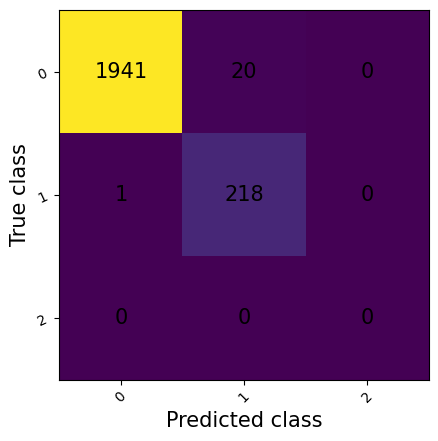

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
shots_for_testing = [16773]
for shot in tqdm(shots_for_testing):
    df = shot_df[shot_df['shot']==shot].reset_index(drop=True)
    dset_for_testing = cmc.ImageDataset(df, path, mean=mean, std=std)
    dloader = DataLoader(dset_for_testing, batch_size=batch_size, shuffle=False)
    predictions_df_dtest, fig_confusion_matrix_dtest, f1_dtest, precision_dtest, recall_dtest, accuracy_dtest = cmc.test_model(
        pretrained_model, dloader)




In [ ]:
shots_for_testing



,time,mode,filename,shot
2181,960.8,0,imgs/RIS1_16769_t=960.8.png,16769
2182,961.0,0,imgs/RIS1_16769_t=961.0.png,16769
2183,961.2,0,imgs/RIS1_16769_t=961.2.png,16769
2184,961.4,0,imgs/RIS1_16769_t=961.4.png,16769
2185,961.6,0,imgs/RIS1_16769_t=961.6.png,16769
...,...,...,...,...
16490,1369.0,0,imgs/RIS1_18057_t=1369.0.png,18057
16491,1369.2,0,imgs/RIS1_18057_t=1369.2.png,18057
16492,1369.4,0,imgs/RIS1_18057_t=1369.4.png,18057
16493,1369.6,0,imgs/RIS1_18057_t=1369.6.png,18057


In [ ]:
test_dataloader.dataset.__len__()

6278

In [ ]:
import re
pattern = re.compile(r'RIS1_(\d+)_t=')

# Extract shot numbers using a list comprehension
shot_numbers = [int(pattern.search(path).group(1)) for path in next(iter(test_dataloader))[2]]

In [ ]:
shot_numbers

[18057,
 16769,
 18130,
 18130,
 16769,
 18057,
 18130,
 18057,
 18130,
 18057,
 18057,
 18130,
 16769,
 18130,
 18130,
 16769,
 18130,
 16769,
 18057,
 18057,
 18057,
 18130,
 18130,
 18057,
 18130,
 18057,
 18057,
 18130,
 18130,
 16769,
 18130,
 18130]

In [ ]:
test_imgs = next(iter(test_dataloader))[0].to(device).float()

In [ ]:
cmc.images_to_probs(pretrained_model, test_imgs)[0][:,1]

tensor([ 4.7360,  4.4382,  9.7772,  5.6418, -0.9460,  2.1114, -1.4919,  5.9128,
         5.2321,  2.4490,  5.7163,  9.6211, -1.5153, -0.8785,  0.4527,  9.1658,
         0.0572,  4.9005, -1.4994,  5.9457,  3.7803,  4.4129,  0.5173,  0.9920,
         4.7426, -1.4576, -1.1690,  5.3980, -1.4972,  5.5125, -1.0812,  9.0756],
       device='cuda:0')

In [ ]:
dataset_sizes

{'train': 8952, 'val': 1952}

In [ ]:
from tqdm.notebook import tqdm
a = torch.tensor([])
for batch in tqdm(test_dataloader):
    a = torch.cat([a, batch[-1]])
    if len(a)>10:
        break

  0%|          | 0/197 [00:00<?, ?it/s]

In [ ]:
a

tensor([1140.6000, 1142.4000, 1257.8000, 1131.6000, 1131.4000, 1054.6000,
        1126.4000, 1139.8000, 1025.8000, 1378.8000, 1195.4000, 1017.6000,
        1356.4000,  962.2000, 1011.0000, 1172.0000, 1141.0000, 1141.4000,
        1383.2000, 1101.8000, 1314.8000, 1225.0000,  963.0000,  981.4000,
        1366.6000, 1132.4000, 1002.2000, 1154.6000, 1335.6000, 1006.8000,
        1020.2000, 1166.8000], dtype=torch.float64)

In [ ]:
test_dataloader.dataset.__getitem__(3)

(tensor([[[ 0.0088,  0.0259, -0.0083,  ..., -0.0083, -0.0083, -0.0083],
          [-0.0083,  0.0088,  0.0259,  ..., -0.0083, -0.0083, -0.0083],
          [-0.0083, -0.0083, -0.0083,  ..., -0.0083,  0.0088,  0.0259],
          ...,
          [-0.0083, -0.0083, -0.0083,  ...,  0.0431,  0.0088, -0.0083],
          [-0.0083, -0.0083, -0.0083,  ..., -0.0083, -0.0083, -0.0083],
          [-0.0083, -0.0083, -0.0083,  ...,  0.0259, -0.0083,  0.0088]],
 
         [[-0.0080, -0.0080,  0.0095,  ..., -0.0080, -0.0080, -0.0080],
          [ 0.0095, -0.0080,  0.0095,  ..., -0.0080, -0.0080, -0.0080],
          [-0.0080,  0.0095, -0.0080,  ..., -0.0080, -0.0080, -0.0080],
          ...,
          [-0.0080, -0.0080, -0.0080,  ...,  0.0095,  0.0270, -0.0080],
          [-0.0080, -0.0080,  0.0095,  ...,  0.0095, -0.0080, -0.0080],
          [-0.0080, -0.0080, -0.0080,  ..., -0.0080, -0.0080,  0.0095]],
 
         [[-0.0071,  0.0104, -0.0071,  ..., -0.0071, -0.0071, -0.0071],
          [-0.0071, -0.0071,